## Ray-Pi

A Monte Carlo estimate of Pi in the spirit of Spark-Pi, using Ray with literate programming in Jupyter

Ray library comes pre-installed on this notebook image:

In [1]:
import os
import random
import ray

import matplotlib.pyplot as plt

Connect to the Ray Server,
Unless we are already connected

In [2]:
ray.init('ray://{ray_head}:10001'.format(ray_head=os.environ['RAY_CLUSTER']))

ClientContext(dashboard_url='10.131.2.243:8265', python_version='3.8.12', ray_version='1.12.1', ray_commit='4863e33856b54ccf8add5cbe75e41558850a1b75', protocol_version='2022-03-16', _num_clients=3, _context_to_restore=<ray.util.client._ClientContext object at 0x7fea1cde6e20>)

One easy way to estimate the value of pi is to generate some random points on the "unit square", or `[-1,1] X [-1,1]`, and then count the number of those points that landed inside the corresponding unit circle.
In the illustration below, the points that landed in our circle are red:

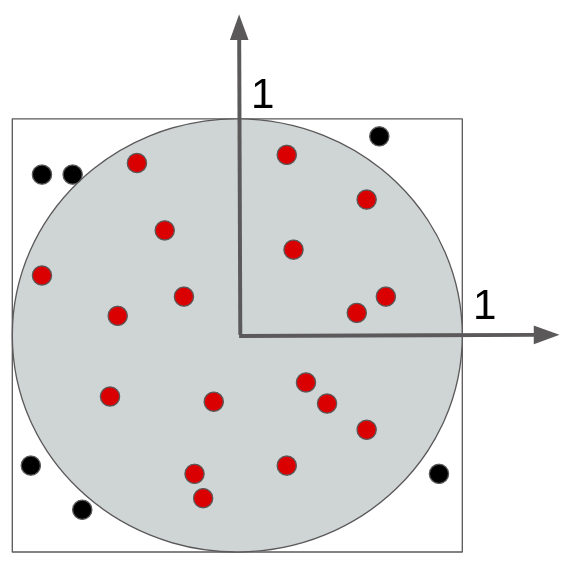

The formula for our estimate is simply 4 times the number of points inside the unit circle, divided by the total number of points we created:

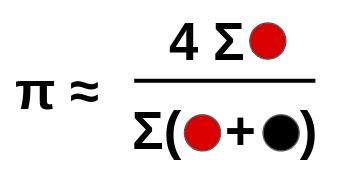

In Spark that computation typically looks something like this:

```python
c = sc.parallelize(range(n*k), k) \
    .map(lambda _: (random.uniform(-1,1), random.uniform(-1,1))) \
    .filter(lambda p: p[0]*p[0] + p[1]*p[1] <= 1) \
    .count()
pi = 4 * c / (n*k)
```

You can see that we first generate some seed data and push it over the network to our Spark cluster,
as the starting point of our computation.

The core of our Ray-Pi implementation can be written in a single, equally short function.
In Ray, we can supply our random points using a python generator, so that we do not need to use `ray.put` across the network.
Instead we only send individual integer counts back over the network!

In [3]:
@ray.remote
def count_in_circle(n):
    # define a generator for points on square
    def random_points(n):
        while n > 0:
            yield (random.uniform(-1,1), random.uniform(-1,1))
            n = n - 1
    # count the number of those points that landed inside unit circle
    return sum(1 for  _ in (p for p in random_points(n) if p[0]*p[0] + p[1]*p[1] <= 1))

Invoking our ray function returns a Ray compute node

In [4]:
c = count_in_circle.remote(1000)
c

ClientObjectRef(d8c1ad1586102897ffffffffffffffffffffffff0400000001000000)

To estimate pi, we `ray.get` our count of points, and apply the formula above:

In [5]:
pi = 4 * ray.get(c) / 1000
print(f"pi= {pi}")

pi= 3.212


We can compute our estimate at larger scale by sending replicated calls to our function to Ray
and letting Ray schedule these replications in parallel:

In [6]:
%%time
# the number of replications (or partitions):
k = 10
# the number of points to compute at each replication:
n = 1000000
x = [count_in_circle.remote(n) for _ in range(k)]
parts = ray.get(x)
c = sum(parts)
pi = 4 * c / (n * k)
print(f"pi= {pi}")

pi= 3.1427144
CPU times: user 7.14 ms, sys: 19.4 ms, total: 26.5 ms
Wall time: 8.42 s


Each partition is its own estimate of pi, and we can print these out easily:

In [7]:
parts = [4 * c / n for c in ray.get(x)]
parts

[3.14058,
 3.140796,
 3.139412,
 3.139312,
 3.144128,
 3.145976,
 3.143972,
 3.142688,
 3.144484,
 3.145796]

We can plot our individual estimates and see how closely they agree with each other

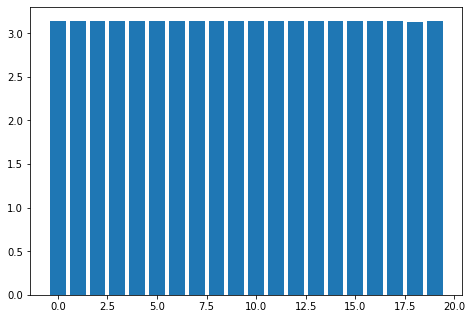

In [8]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
n = 100000
x = [count_in_circle.remote(n) for _ in range(20)]
parts = [4 * c / n for c in ray.get(x)]
ax.bar(range(len(parts)),parts)
plt.show()

The differences between each sample are hard to see in the plot above.

To see better, we can narrow the range on our y-axis, and plot the true value of pi as a comparison:

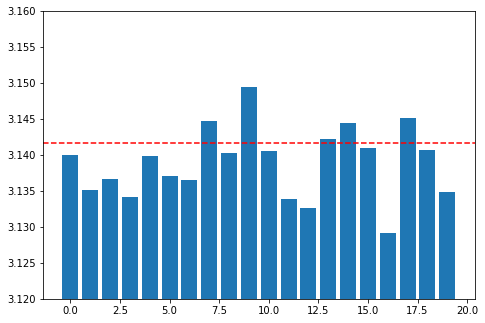

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
n = 100000
x = [count_in_circle.remote(n) for _ in range(20)]
parts = [4 * c / n for c in ray.get(x)]
ax.bar(range(len(parts)),parts)
# zoom in on the y axis:
plt.ylim(3.12, 3.16)
# mark the true value of pi as a line:
plt.axhline(y=3.14159265, linestyle="--", color="red")
plt.show()